# Hybrid Vision Transformer (ViT) for facial image classification based on gender

## Prerequisites
1. Linux OS
2. Conda Environment installed according to the steps from https://github.com/pgagarinov/pytorch-hyperlight/blob/main/products/jupyterlab-ml-devenv/README.md
3. PyTorch-Hyperlight package `pip install pytorch-hyperlight`

In [1]:
import os
import logging
import warnings
from pathlib import Path
from git import Repo
import pytorch_hyperlight as pth
import pytorch_pretrained_vit
import torch
from pytorch_hyperlight.datasets.kaggle.utkfaces import UTKFacesDataLoadersBuilder
from pytorch_hyperlight.tasks.classification import (
    AAutoClsHeadClassificationTaskAdamStepLR,
)
import numpy as np
from pytorch_hyperlight.utils.request_utils import copy_urls_to_files

In [2]:
FAST_DEV_RUN = False  # if true, simplifed configurations running for just a few epochs are used for making sure there are no obvious bugs

## Loading data from UTKFace dataset

Let us look at the data after all the data augmentation transformations

In [3]:
EXPERIMENT_ID = "vit-utk-faces"

In [4]:
SEED = 16

In [5]:
if "workbookDir" not in globals():
    workbookDir = os.getcwd()
WORKBOOK_DIR = Path(workbookDir)

In [6]:
IMAGE_SIZE = 224

In [7]:
f_create_dataloaders, f_create_datasets = UTKFacesDataLoadersBuilder(
    seed=SEED, root_path=WORKBOOK_DIR / "datasets", image_size = IMAGE_SIZE
).build()

In [8]:
warnings.filterwarnings("ignore")

In [9]:
BATCH_SIZE = 32
loaders_dict = f_create_dataloaders(BATCH_SIZE)
batch = next(iter(loaders_dict["test_loader"]))

Global seed set to 16


In [10]:
assert len(batch[0]) > 0

In [11]:
assert all([x == IMAGE_SIZE for x in batch[0][0].shape[1:]])

### Standard Vision Transformer vs Hybrid Vision Transformer

Let us use our training set to fine-tune Vision Transformer "B_16_imagenet1k" (which is pretrained on "ImageNet-21k" and fine-tuned on "ImageNet-1k") from [PyTorch-Pretrained-ViT](https://github.com/lukemelas/PyTorch-Pretrained-ViT) GitHub project

We'll use a double-layered FC classification head with biases initialized with zeros to make sure we do not introduce any unnecessary bias to the transformers heads. Dropout between the layeres should help with overfitting.

Since we will compare Vision Transformers under the same settings we can safely use the same metrics calculation logic, criterions and optimizers. All this is mostly implemented in a reusable `AAutoClsHeadClassificationTaskAdamStepLR` class imported from PyTorch-Hyperlight. 

In [12]:
N_CLASSES = loaders_dict["n_classes"]
IS_CUDA = torch.cuda.is_available()
GPU_PER_TRIAL = 0.3 * IS_CUDA

We use batch size = 16 for both compared models. In fact, ViT allows for maximum batch size = 32 for this particular task and RTX 2070 8Gb GPU with 16bit precision. The maximum batch size for EfficientNet on the same hardware is 16. However we do not want the batch size to be different for different models as it might impact model performance.

In [13]:
CONFIG = {
    "classifier_lr": 1e-3,
    "rest_lr": 1e-5,
    "step_lr_gamma": 0.6,
    "step_lr_step_size": 1,
    "classifier_dropout": 0.2,
    "gradient_clip_val": 0,
    "max_epochs": 10,  # the actual number can be less due to early stopping
    "batch_size": 14,
    "n_classes": N_CLASSES,
}

EXTRA_CONFIG = {
    "seed": SEED,  # just remove this if you do not want determenistic behavior
    "metric_to_optimize": "val_f1_epoch",  # Ray + PTL Trainer
    "ray_metrics_to_show": [
        "val_loss_epoch",
        "val_f1_epoch",
        "val_acc_epoch",
    ],  # for Ray Tune
    "metric_opt_mode": "max",  # Ray + PTL Trainer
    "cpu_per_trial": 3,  # Ray + DataLoaders
    "gpu_per_trial": GPU_PER_TRIAL,  # for Ray Tune
    "n_checkpoints_to_keep": 1,  # for Ray Tune
    "grace_period": 0,  # for both PTL Trainer and Ray Tune scheduler
    "epoch_upper_limit": 45,  # for Ray Tune
    "n_samples": 3,  # for Ray Tune
    "ptl_early_stopping_patience": 3,  # for PTL Trainer
    "ptl_precision": 16,  # or 16, for PTL Trainer
    "train_loader_name": "train_augmented_loader",
    "val_loader_name": "val_loader",
    "test_loader_name": "test_loader",
    "batch_size_main": CONFIG[
        "batch_size"
    ],  # batch size for revalidation and test phases
    #    that run in the main process after all Ray Tune child processes are finished
    "gpus": -1 * IS_CUDA,  # -1 - use GPU if available, 0 - use CPU, 1 - use single GPU,
    # >=2 - use multiple GPUs
}

if FAST_DEV_RUN:
    CONFIG["max_epochs"] = 2
    EXTRA_CONFIG["n_samples"] = 2

The `Runner` class from PyTorch-Hyperlight hides all the technicalities related to training, validation and testing of the model. 

In [14]:
runner = pth.Runner(
    f_create_dataloaders,
    is_debug=FAST_DEV_RUN,
    experiment_id=EXPERIMENT_ID,
    log2wandb=False,
)

We will use `run_single_trial` method of `Runner` to run a single `trial` i.e a single cycle of training-validation-testing. Please note that we do not pass an instance of our PyTorch-Lightning module into `Runner`. Instead we just pass a class name of our model and let `Runner` instantiate the module by itself.

### Fine-tuning Vision Transformer from PyTorch-Pretrained-ViT

Based on various experiments ViT seem to work betweet without gradient clipping while EfficientNet seems to work better with the gradient clipping turned on.

In [15]:
class ViTClassifier(AAutoClsHeadClassificationTaskAdamStepLR):
    def __init__(self, hparams):
        MODEL_NAME = 'B_16_imagenet1k'
        model = pytorch_pretrained_vit.ViT(
            MODEL_NAME, image_size=IMAGE_SIZE, pretrained=True
        )
        super().__init__(hparams, model)

    def _get_classifier_module_name(self):
        return "fc"

In [16]:
"""
config = CONFIG.copy()
best_result = runner.run_single_trial(
    ViTClassifier, config, EXTRA_CONFIG
)

print(best_result['trainer'].checkpoint_callback.best_model_path)

del best_result
"""

"\nconfig = CONFIG.copy()\nbest_result = runner.run_single_trial(\n    ViTClassifier, config, EXTRA_CONFIG\n)\n\nprint(best_result['trainer'].checkpoint_callback.best_model_path)\n\ndel best_result\n"

### Fine-tuning of Vision Transformer from ViT-Pytorch

In [17]:
VIT_PYTORCH_GIT_REPO_URL = "https://github.com/jeonsworld/ViT-pytorch"

In [18]:
VIT_PYTORCH_REPO_DIR = WORKBOOK_DIR / "ViT-pytorch"

In [19]:
if not VIT_PYTORCH_REPO_DIR.is_dir():
    Repo.clone_from(VIT_PYTORCH_GIT_REPO_URL, VIT_PYTORCH_REPO_DIR)
else:
    logging.info(f"GAN_REPO_DIR = {VIT_PYTORCH_REPO_DIR} already exists")

In [20]:
os.chdir(VIT_PYTORCH_REPO_DIR)
from models.modeling import CONFIGS, VisionTransformer

In [21]:
VIT_PYTORCH_MODEL_DATA_DIR = VIT_PYTORCH_REPO_DIR / 'model_data'
Path.mkdir(VIT_PYTORCH_MODEL_DATA_DIR, exist_ok=True)

In [22]:
class VisionTransformerSkipAttOutput(VisionTransformer):
    def forward(self, x):
        logits, att_mat = super().forward(x)
        self.att_mat = att_mat
        return logits

In [23]:
class VitAlternativeClassifier(AAutoClsHeadClassificationTaskAdamStepLR):
    def __init__(self, hparams):
        self.save_hyperparameters(hparams)
        model_name = hparams["model_name"]
        VIT_PYTORCH_MODEL_DATA_FILE_NAME = f"{model_name}.npz"
        VIT_PYTORCH_MODEL_DATA_FILE_PATH = (
            VIT_PYTORCH_MODEL_DATA_DIR / VIT_PYTORCH_MODEL_DATA_FILE_NAME
        )
        VIT_PYTORCH_MODEL_DATA_URL = f"https://storage.googleapis.com/vit_models/imagenet21k/{VIT_PYTORCH_MODEL_DATA_FILE_NAME}"

        if not VIT_PYTORCH_MODEL_DATA_FILE_PATH.exists():
            copy_urls_to_files(
                VIT_PYTORCH_MODEL_DATA_URL, VIT_PYTORCH_MODEL_DATA_FILE_PATH
            )
        config = CONFIGS[model_name.replace("+", "-")]
        model = VisionTransformerSkipAttOutput(
            config,
            zero_head=False,
            img_size=IMAGE_SIZE,
            vis=True,
        )
        model.load_from(np.load(VIT_PYTORCH_MODEL_DATA_FILE_PATH))
        super().__init__(hparams, model)

    def _get_classifier_module_name(self):
        return "head"

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
Global seed set to 16
Global seed set to 16
Global seed set to 16

  | Name              | Type                           | Params
---------------------------------------------------------------------
0 | model             | VisionTransformerSkipAttOutput | 98.5 M
1 | criterion         | CrossEntropyLoss               | 0     
2 | train_metric_calc | LitMetricsCalc                 | 0     
3 | val_metric_calc   | LitMetricsCalc                 | 0     
4 | test_metric_calc  | LitMetricsCalc                 | 0     
---------------------------------------------------------------------
98.5 M    Trainable params
0         Non-trainable params
98.5 M    Total params


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

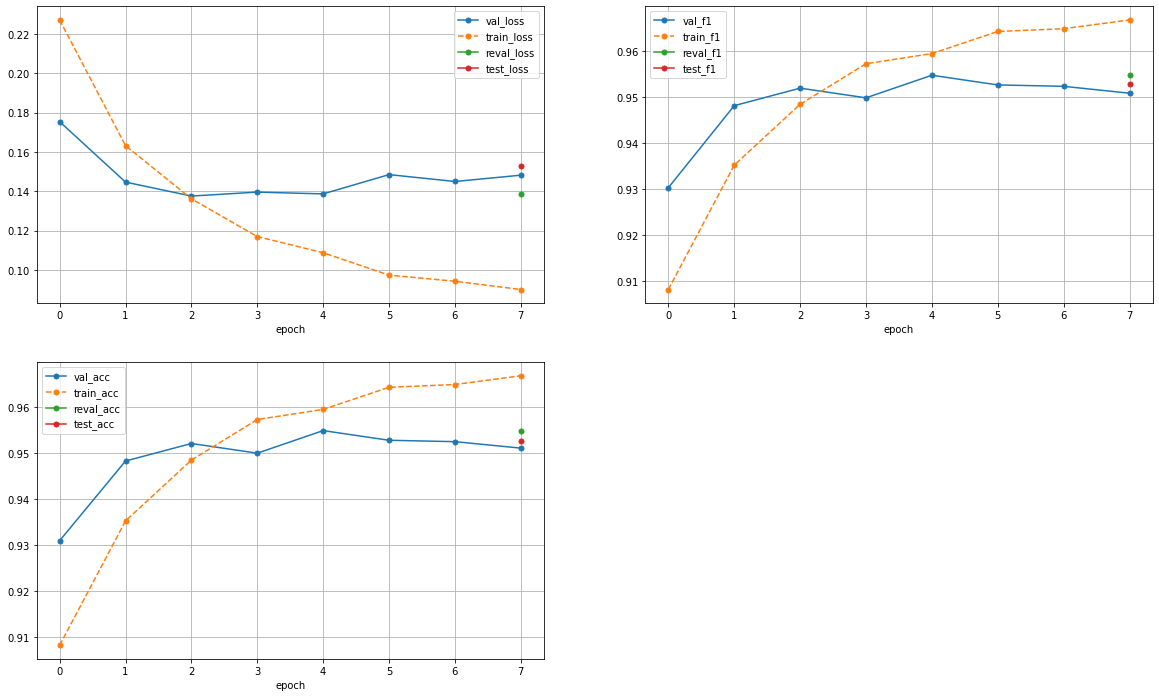

Global seed set to 16


Testing: |          | 0/? [00:00<?, ?it/s]

Global seed set to 16


/home/peter/_Git/_ML/_DLSchool/dlschool-solutions/term2/project/peter/vit_pytorch_vis_attention/ViT-pytorch/checkpoints/epoch=4-step=6354.ckpt


In [24]:
config = CONFIG.copy()
config["model_name"] = "R50+ViT-B_16"
best_result = runner.run_single_trial(
    VitAlternativeClassifier,
    config,
    EXTRA_CONFIG,
    extra_run_name_prefix=config["model_name"] + "-",
)
print(best_result['trainer'].checkpoint_callback.best_model_path)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
Global seed set to 16
Global seed set to 16
Global seed set to 16

  | Name              | Type                           | Params
---------------------------------------------------------------------
0 | model             | VisionTransformerSkipAttOutput | 86.4 M
1 | criterion         | CrossEntropyLoss               | 0     
2 | train_metric_calc | LitMetricsCalc                 | 0     
3 | val_metric_calc   | LitMetricsCalc                 | 0     
4 | test_metric_calc  | LitMetricsCalc                 | 0     
---------------------------------------------------------------------
86.4 M    Trainable params
0         Non-trainable params
86.4 M    Total params


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

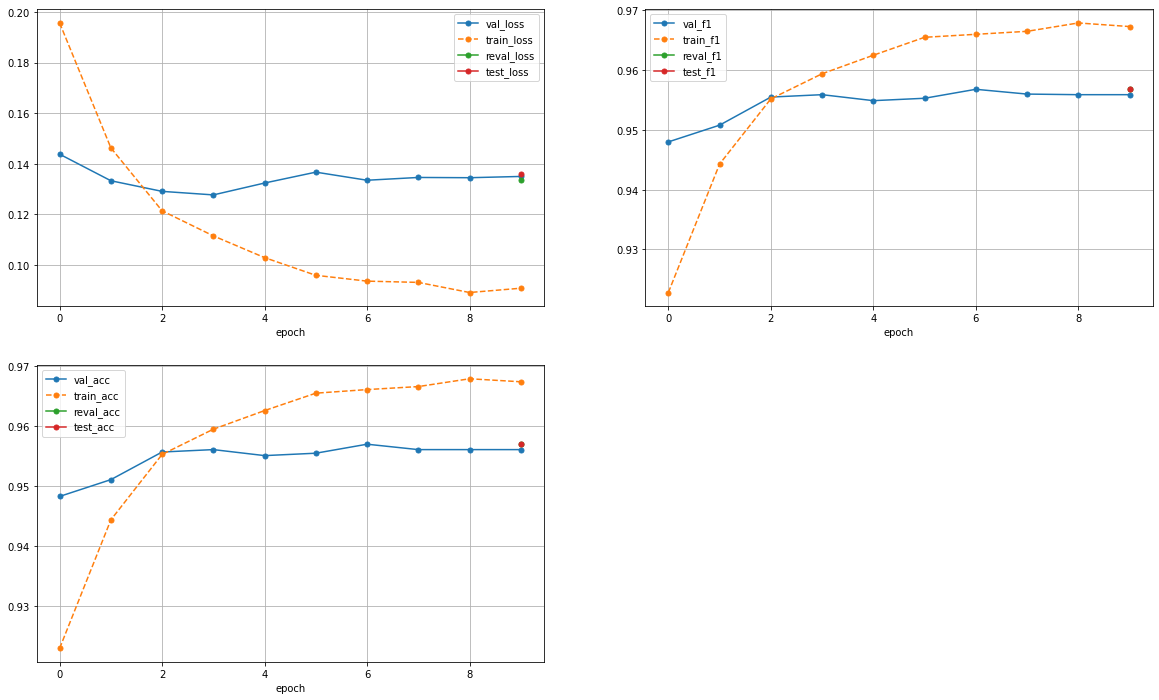

Global seed set to 16


Testing: |          | 0/? [00:00<?, ?it/s]

Global seed set to 16


/home/peter/_Git/_ML/_DLSchool/dlschool-solutions/term2/project/peter/vit_pytorch_vis_attention/ViT-pytorch/checkpoints/epoch=6-step=8896.ckpt


In [25]:
config = CONFIG.copy()
config["model_name"] = "ViT-B_16"
best_result = runner.run_single_trial(
    VitAlternativeClassifier,
    config,
    EXTRA_CONFIG,
    extra_run_name_prefix=config["model_name"] + "-",
)
print(best_result['trainer'].checkpoint_callback.best_model_path)

,test_f1,test_acc,run
11,0.9569,0.957,ViT-B_16-single-trial-VitAlternativeClassifier
9,0.9527,0.9527,R50+ViT-B_16-single-trial-VitAlternativeClassi...


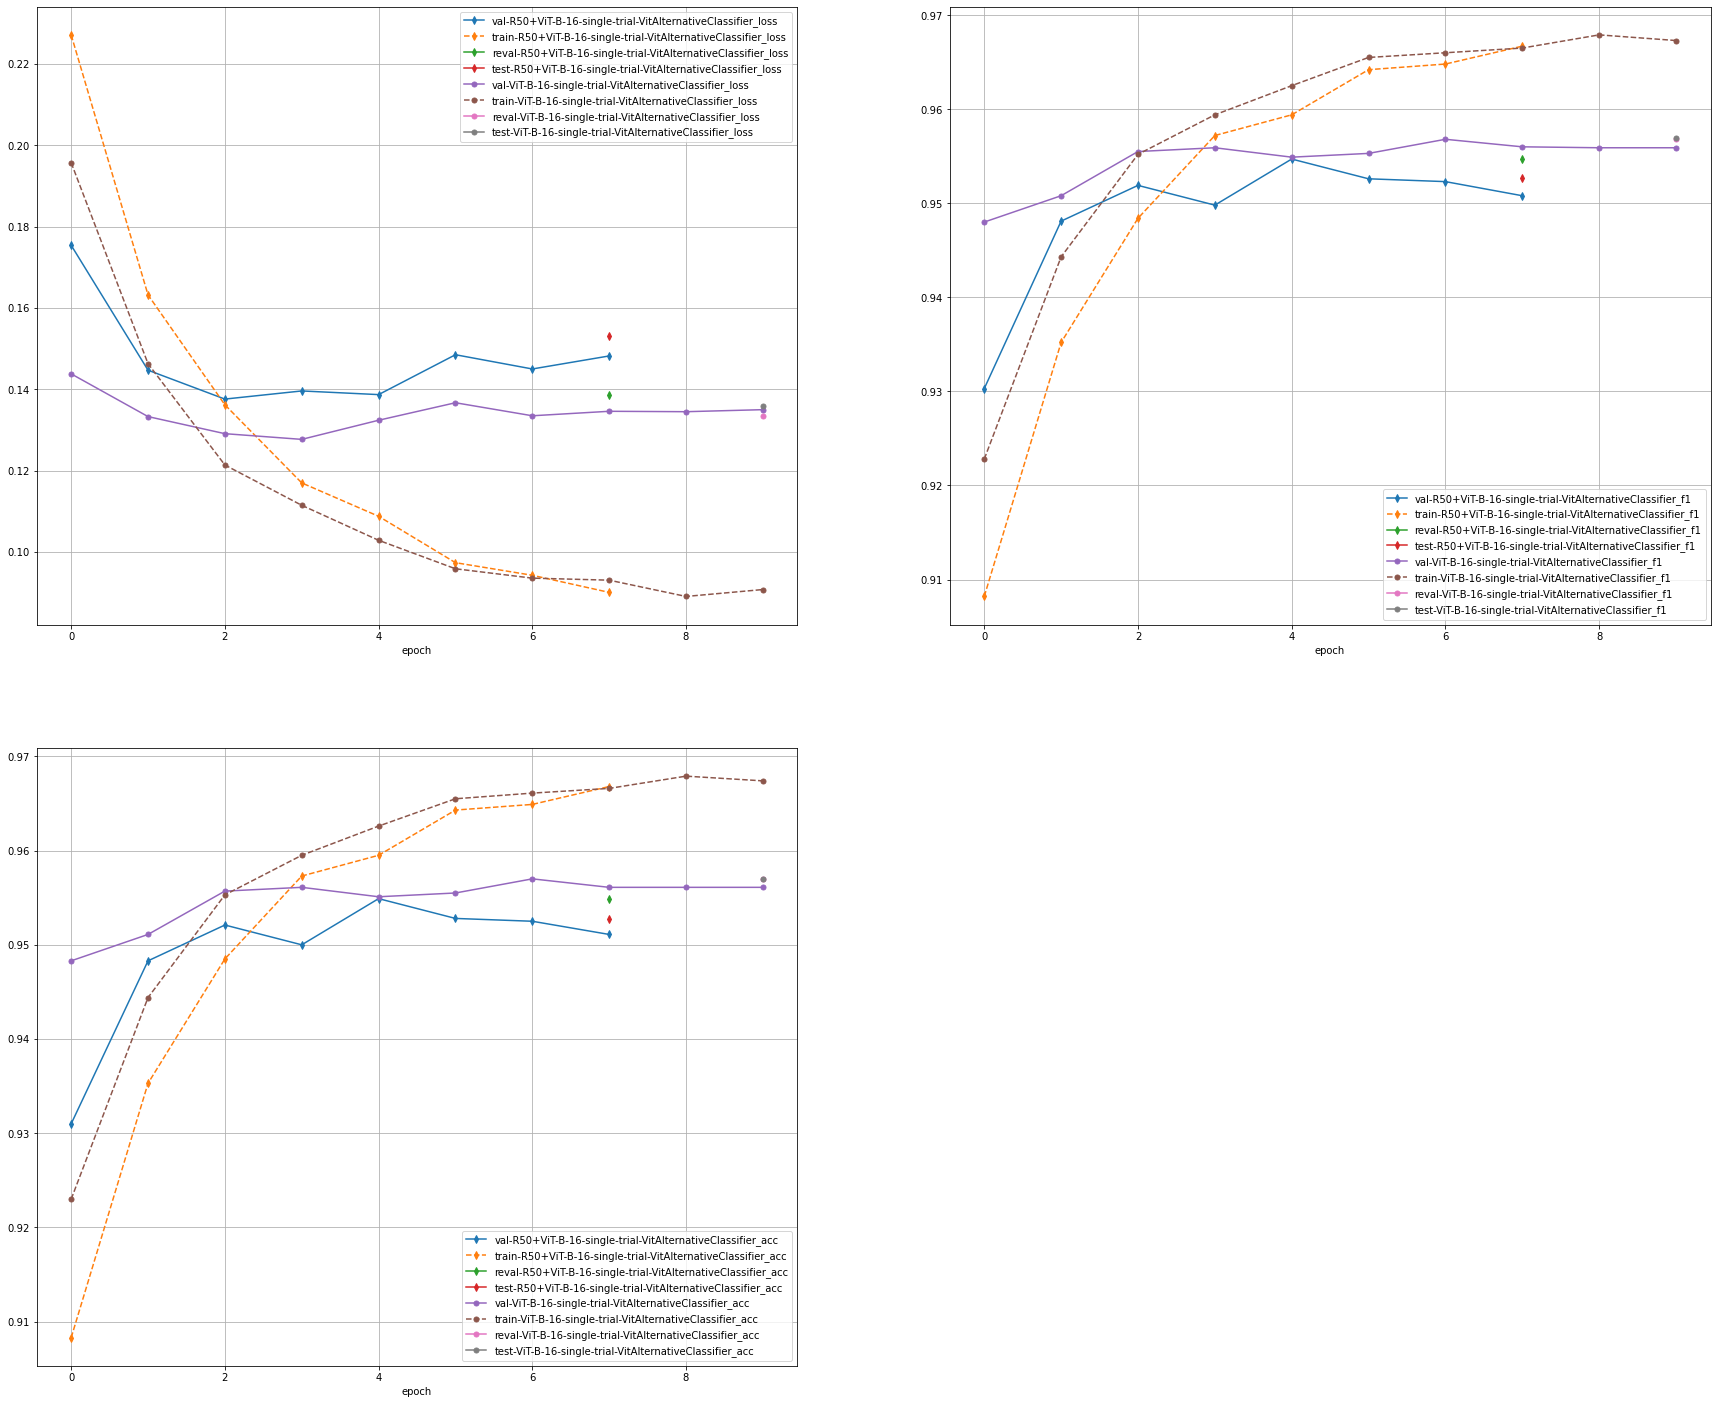

In [26]:
runner.show_metric_report(sort_by_metric_list=["test_f1", "test_acc"], figsize=(30, 25))

## References

[1] "Attention Is All You Need", Ashish Vaswani and Noam Shazeer and Niki Parmar and Jakob Uszkoreit and Llion Jones and Aidan N. Gomez and Lukasz Kaiser and Illia Polosukhin,
      2017,
      [arXiv/1706.03762](https://arxiv.org/abs/1706.03762)
    
[2]. "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale", Alexey Dosovitskiy and Lucas Beyer and Alexander Kolesnikov and Dirk Weissenborn and Xiaohua Zhai and Thomas Unterthiner and Mostafa Dehghani and Matthias Minderer and Georg Heigold and Sylvain Gelly and Jakob Uszkoreit and Neil Houlsby, 2020, [arXiv/2010.11929](https://arxiv.org/abs/2010.11929)

[3] [Vision Transformer](https://github.com/google-research/vision_transformer) GitHub repo with original implementation of Vision Transformer in Jax by Google

[4] [PyTorch-Pretrained-ViT](https://github.com/lukemelas/PyTorch-Pretrained-ViT) GitHub project